## EXPERIMENTOS CON ICA

En este Notebook se hace una serie de experimentos con los parámetros del método ICA aplicado sobre la señal de EEG filtrada.

IMPORT MODULES

In [1]:
import mne
from TFG_utils import returnFiles, take_vmrk_files, take_vhdr_files, take_eeg_files, plot_freq_response, plot_PSD, plot_eeg_channel_corrected, plot_residual_PSD, plot_spots
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn.decomposition import PCA

In [2]:
print('MNE version:',mne.__version__)
#%matplotlib qt
verbose= True

MNE version: 0.20.7


#### COLLECTING DATA

In [3]:
foldername = 'EEG_folders'
EEG_files= returnFiles(foldername)

vmrk_files= take_vmrk_files(EEG_files)
vhdr_files= take_vhdr_files(EEG_files)
eeg_files= take_eeg_files(EEG_files)

i= 3 # Choosing EEG recording to use

vmrk_filename= vmrk_files[i]
vhdr_filename= vhdr_files[i]
eeg_filename= eeg_files[i]

raw_eeg = mne.io.read_raw_brainvision(vhdr_files[i],verbose=verbose).load_data(verbose=verbose).set_montage("standard_1020", verbose= verbose)
data,times= raw_eeg[:]
info= raw_eeg.info
fs= int(info['sfreq'])

#Selecting channel to represent:
ch = 2 #Channel F3
#ch = 28 #Channel F4
#ch = 3 #Channel F7
#ch = 29 #Channel F8

subject= eeg_filename[-8:-4]
print('Sujeto:',subject)
print('Canal:', info['ch_names'][ch])

Extracting parameters from EEG_folders\eeg_example_5\Neuromarketing2900.vhdr...
Setting channel info structure...
Reading 0 ... 252619  =      0.000 ...   505.238 secs...
Sujeto: 2900
Canal: F3


#### FILTERING DATA

In [4]:
f1,f2=(1,40)
eeg_filtered= raw_eeg.copy().set_montage("standard_1020", verbose= verbose)
eeg_filtered.filter(l_freq=f1, h_freq=f2, filter_length='auto', method='fir',fir_window='hamming',
                      fir_design='firwin', verbose= verbose)
eeg_filtered.notch_filter([50,100,150,200], filter_length='auto', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

# ICA

#### PCA

Cumulative variance calculation to estimate how many components we need to perform the ICA algorithm (n_components)

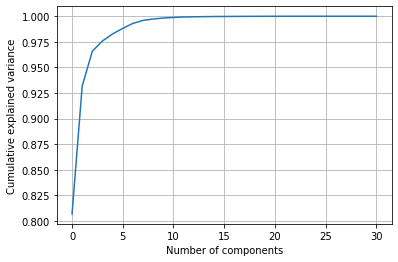

In [5]:
pca = PCA(n_components=None).fit(eeg_filtered['all'][0])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

In [6]:
n_components=10

In [7]:
#%matplotlib qt
%matplotlib notebook

### 'FastICA' method

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 31 components
Fitting ICA took 29.0s.


<IPython.core.display.Javascript object>


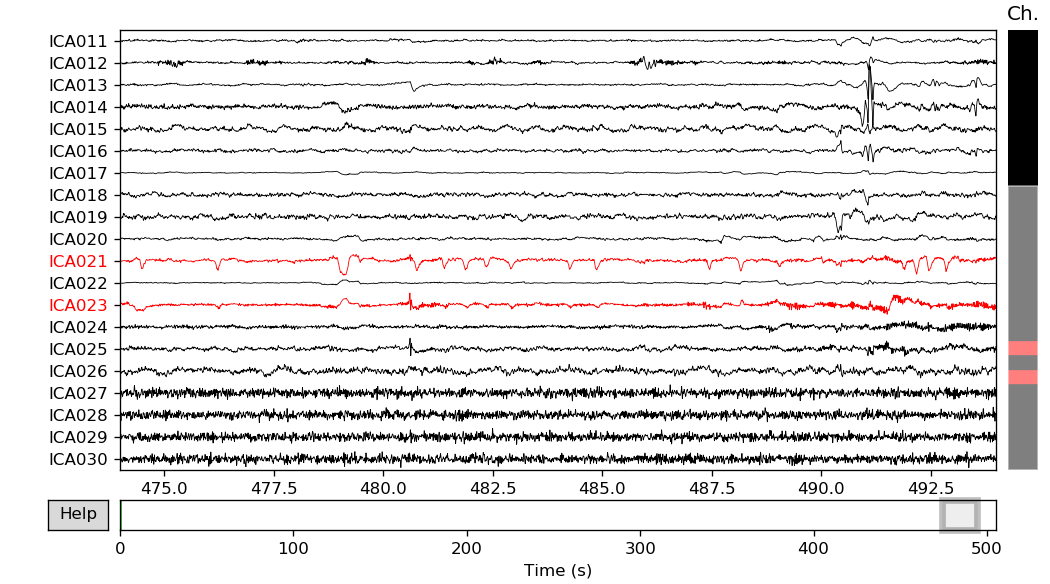

In [8]:
#ica_fastica = mne.preprocessing.ICA(n_components=n_components, method='fastica', random_state=1, verbose=verbose, fit_params=dict(tol=5)).fit(eeg_filtered)
ica_fastica = mne.preprocessing.ICA(method='fastica', random_state=1, verbose=verbose).fit(eeg_filtered)
ica_fastica.plot_sources(eeg_filtered)
plt.show()

<IPython.core.display.Javascript object>


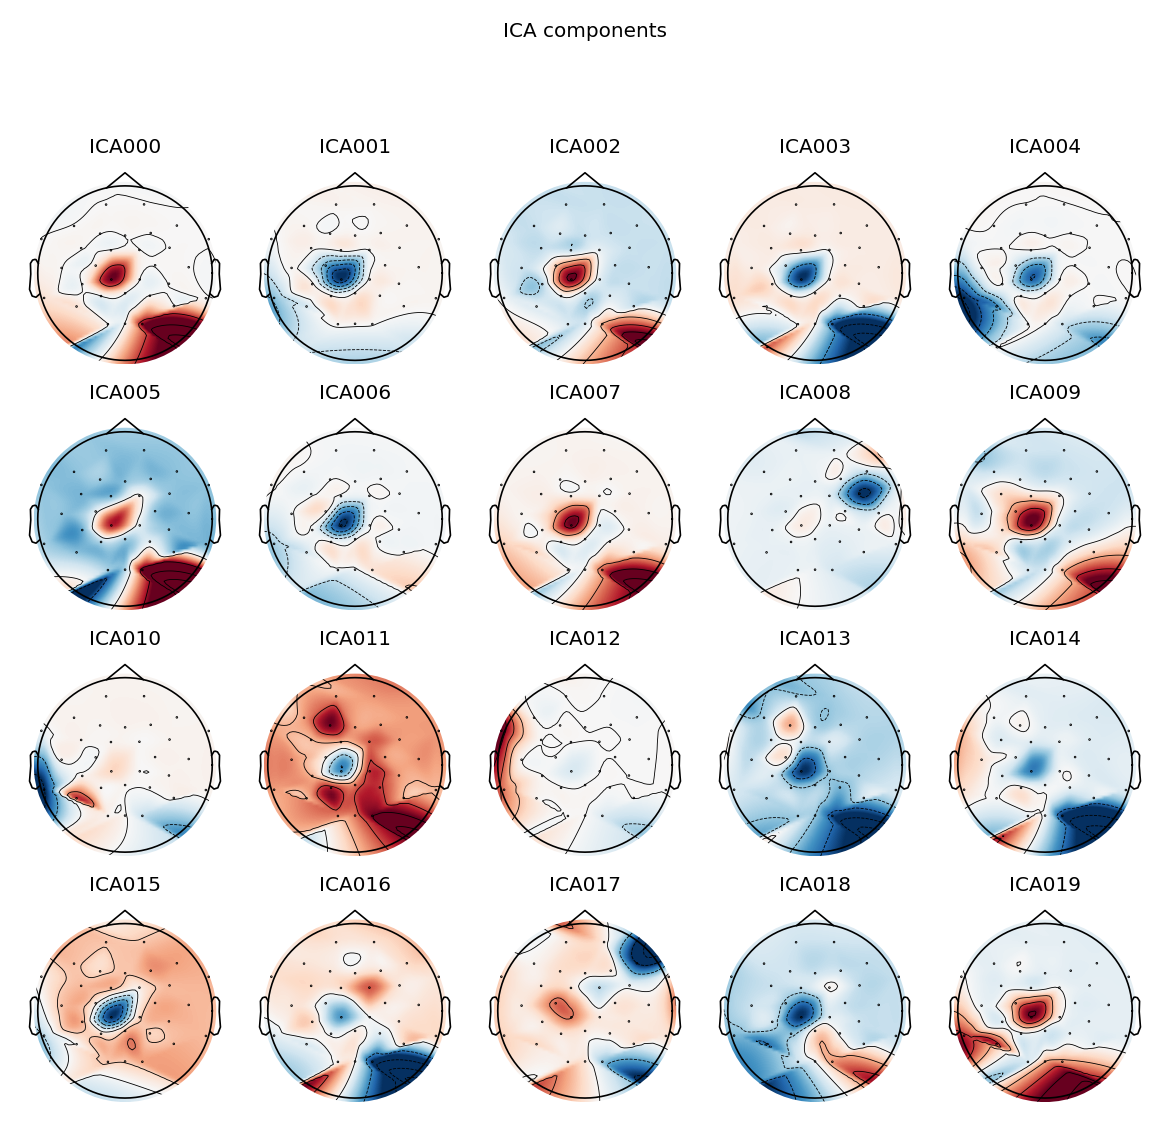

<IPython.core.display.Javascript object>


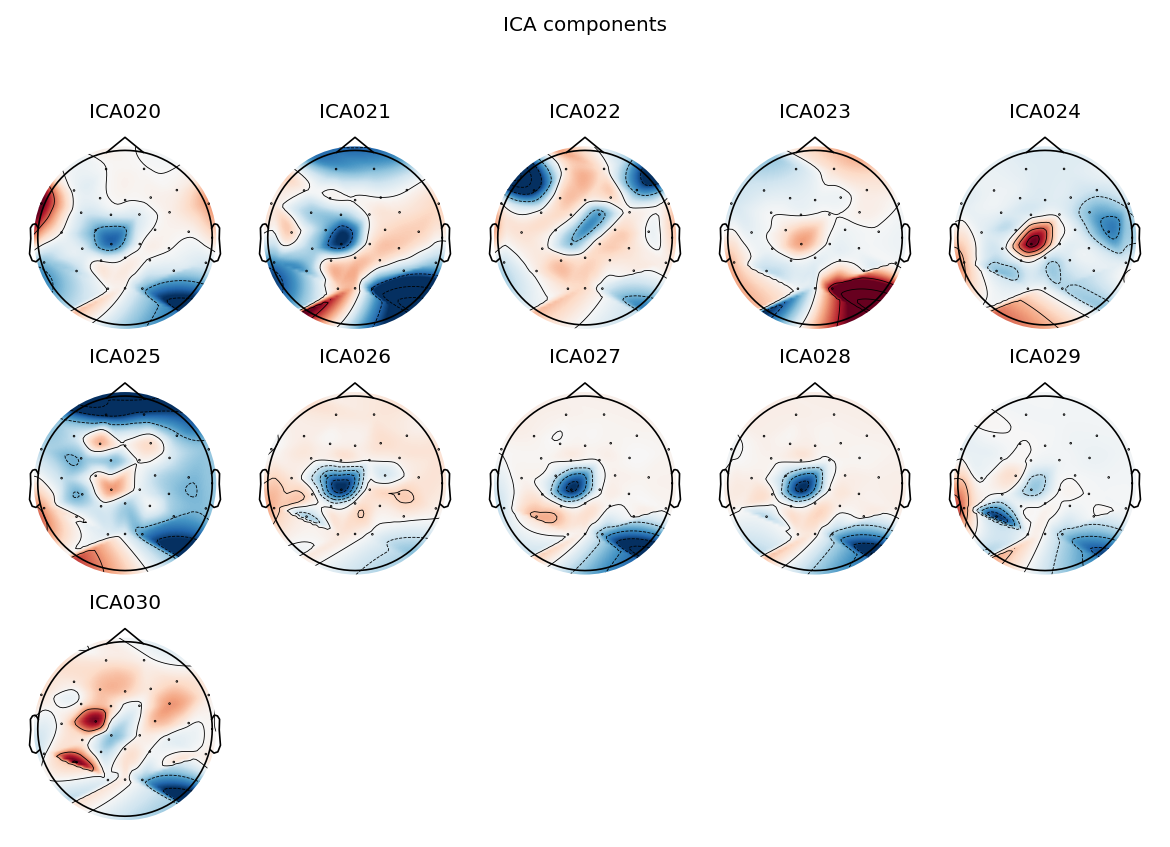

In [9]:
ica_fastica.plot_components()
plt.show()

EXCLUDE

Transforming to ICA space (31 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


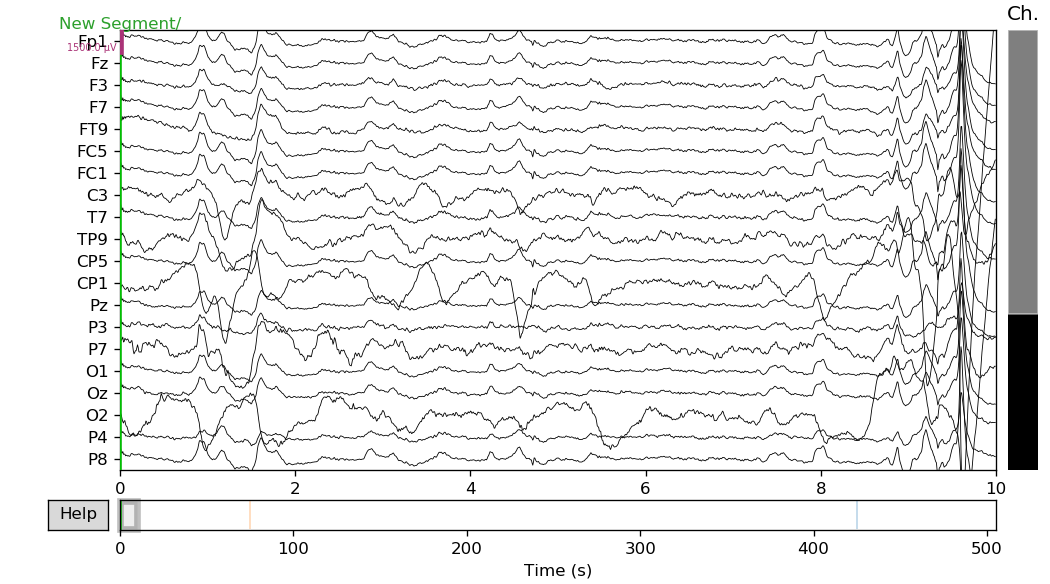

In [10]:
ica_fastica.exclude = [21,23]
raw_corrected = eeg_filtered.copy()
ica_fastica.apply(raw_corrected)

raw_corrected.plot(scalings={"eeg": 75e-5},title='After ICA', verbose=verbose)
plt.show()

### 'Infomax' method

In [11]:
ica_infomax = mne.preprocessing.ICA(method='infomax', random_state=1, fit_params=dict(extended=True), verbose=True).fit(eeg_filtered)
ica_infomax.plot_sources(eeg_filtered)
plt.show()

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 31 components
Computing Extended Infomax ICA


KeyboardInterrupt: 

In [ ]:
ica_infomax.plot_components()
plt.show()

EXCLUDE

In [ ]:
ica_infomax.exclude = [0,21]
raw_corrected = eeg_filtered.copy()
ica_infomax.apply(raw_corrected)

raw_corrected.plot(scalings={"eeg": 75e-5},title='After ICA (spot 2)', verbose=verbose)
plt.show()

### 'Picard' method

In [ ]:
ica_picard = mne.preprocessing.ICA(method='picard', random_state=1, fit_params=dict(extended=True),verbose=True).fit(eeg_filtered)
ica_picard.plot_sources(eeg_filtered)
plt.show()

In [ ]:
ica_picard.plot_components()
plt.show()

EXCLUDE

In [ ]:
ica_picard.exclude = [7,9]
raw_corrected = eeg_filtered.copy()
ica_picard.apply(raw_corrected)

raw_corrected.plot(scalings={"eeg": 75e-5},title='After ICA (spot 2)', verbose=verbose)
plt.show()

# MÁS

<IPython.core.display.Javascript object>


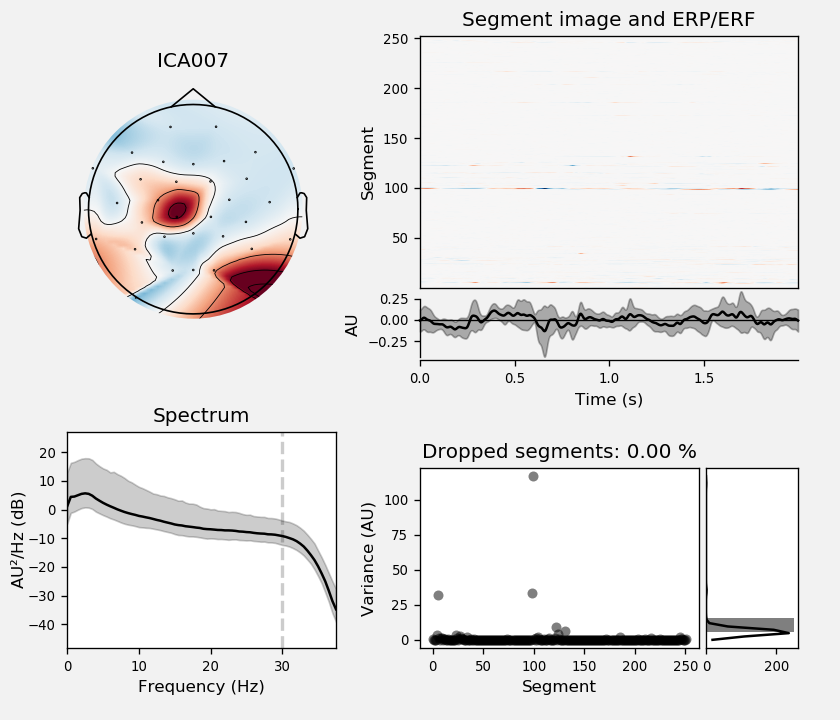

    Using multitaper spectrum estimation with 7 DPSS windows
252 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<IPython.core.display.Javascript object>


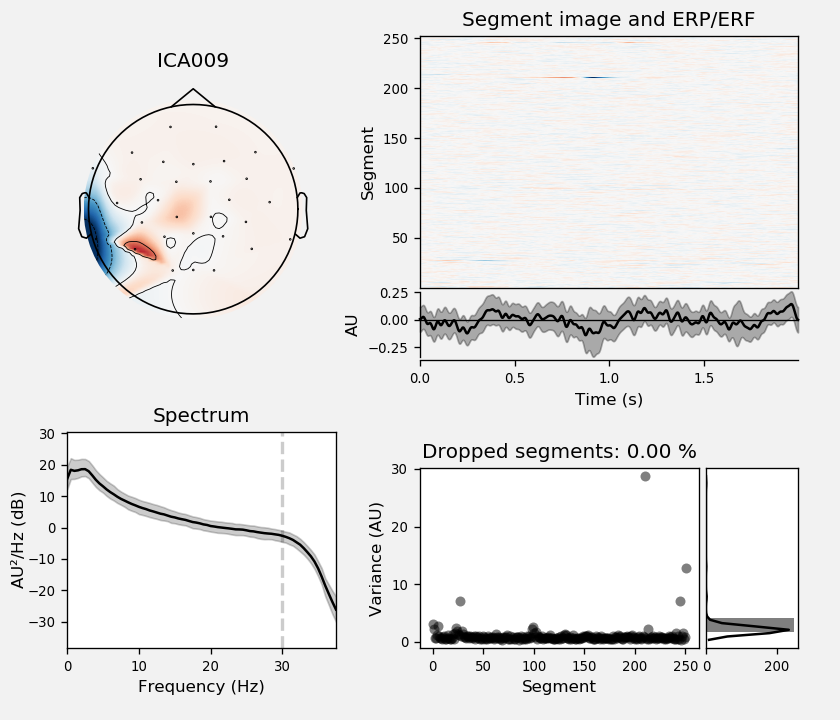

252 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Transforming to ICA space (31 components)
Zeroing out 5 ICA components


<IPython.core.display.Javascript object>


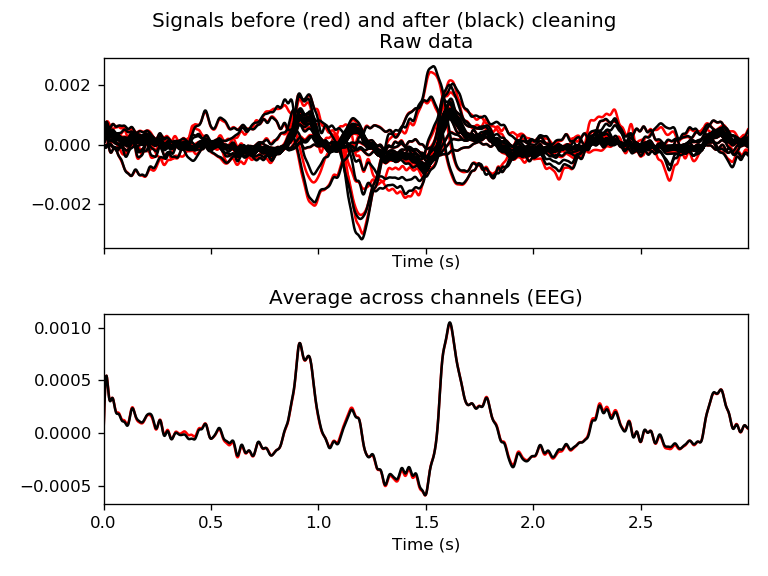

In [17]:
ica_fastica.plot_properties(eeg_filtered, picks=[7,9], dB=True, plot_std=True)
plt.show()

ica_picard.plot_overlay(eeg_filtered, exclude=[20,25,26])
plt.show()